# Google Trends insight in understanding what drives Norwegians into purchasing an electric vehicle
Authors: 
- 270226 - Max Chevron 
- 321733 - Shasha Jiang 
- 314205 - Jostein Leirgulen 

Date: 03.12.2020 

### Abstract:

Norway is well advanced compared to other countries in the expansion of its electric vehicle (EV) fleet thanks to strong incentives (100% tax for combustion vehicles which are exempted for EV). It has even reached the top place in total EV sales despite its country size. Understanding the evolution of EV car sales in Norway could help predicting future sales in other countries. 

Now that we have a working model to assess the predictive power of Google Trends on a certain output, we will then extend this on investigating which set of indicators best improve the short-term prediction of a Norway EV sales. The indicators will be grouped in categories such as environment, car models, infrastructure or policy related. Additionally, we will assess the impact of corner-stone events such as the Paris Climate Accord, the release of the Tesla model 3 as well as the implementation of tax-cuts for EVs in Norway on car sales. All of this will help us assess which category of indicators/events influence most the consumer propensity to switch from combustion to electric.

### Research Questions:

- Which category of indicators influence most EV sales in Norway?  Is it environment, car models, infrastructure (charging stations) or government policies?
- Which event influenced most EV sales in Norway (the Paris Climate Accord, the release of the Tesla model 3 or the implementation of tax-cuts for EVs in Norway)?
- Is there a coherent correlation between the answers of both questions above? 

### Proposed dataset:

1) Opplysningsrådet for Veitrafikk - Road Traffic Information Council

- https://ofv.no/ 
- The data should be bought but as students we managed to request it for free
- We have not accessed the data yet, so we do not know the full content of it and cannot infer its size yet. Most probably it would be at around 100 rows (1 per month for 10 years).

2) Google Trends:

- https://trends.google.com/trends
- We will pick several indicators and investigate which ones help us best in predicting. Indicators will be grouped in these categories:
  - Environment
  - Car models
  - Infrastructure (charging stations)
  - Government policies

### Methods:

We will: 

- use the same method in the paper for Motor Vehicles and Parts,  select relevant terms for google trends
- do several experiments to find a suitable match
- use the expanding window to train the data and make prediction

The models will be:

- Base model features: 1 month lag + 12 month lag
- Indicators model features: 
  - Base + environment related indicators
  - Base + car model related indicators
  - Base + infrastructure related indicators
  - Base + government policies related indicators
  - Base + all indicators
- Indicators and events model features (Discontinuous regression model): 
  - Base + all indicators + Paris Climate accord passed? [0,1] + Tesla model 3 released? [0,1] + Norway EV tax-cut implemented? [0,1]

In [5]:
import pandas as pd 
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from pytrends.request import TrendReq

### Step 1 - EV sales data wrangling

In [60]:
sales = pd.read_csv('data/EV_sales_norway.csv',sep=';')

In [105]:
sales['weekday'] = ''
pd.to_datetime(sales['weekday'])
for index, row in sales.iterrows():
    sales.weekday[index] = datetime.strptime('{} {} 1'.format(row.year, row.week-1), '%Y %W %w').strftime("%Y-%m-%d") # minus 1 because the dataset week system goes from 1 to 53 instead of 0 to 52
sales.weekday = pd.to_datetime(sales.weekday, format='%Y-%m-%d')
sales.head(3)

,year,week,other,electric,weekday
0,2010,1,17,0,2009-12-28
1,2010,2,2776,0,2010-01-04
2,2010,3,1953,0,2010-01-11


Text(0, 0.5, 'Weekly car sales')

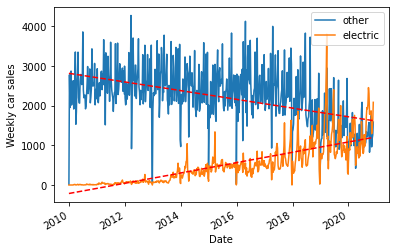

In [115]:
sales.plot('weekday', y=["other", "electric"])

# calc the trendline
z_other = np.polyfit(sales.index, sales.other, 1)
z_elec = np.polyfit(sales.index, sales.electric, 1)
p_other = np.poly1d(z_other)
p_elec = np.poly1d(z_elec)
plt.plot(sales.weekday,p_other(sales.index),"r--")
plt.plot(sales.weekday,p_elec(sales.index),"r--")
plt.xlabel('Date')
plt.ylabel('Weekly car sales')

Text(0.5, 1.0, 'EVs in Norway')

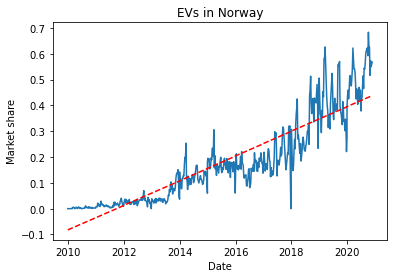

In [135]:
x = sales.weekday
y = sales.electric/(sales.electric+sales.other)
plt.plot(x,y)

# calc the trendline
z_elec = np.polyfit(sales.index, y, 1)
p_elec = np.poly1d(z_elec)
plt.plot(x,p_elec(sales.index),"r--")
plt.xlabel('Date')
plt.ylabel('Market share')
plt.title('EVs in Norway')

### Step 2 - Google trend data import and wrangling

In [158]:
'''
Function goal:      Import Google Trends data
Function inputs:    kw = Keyword list 
                    hl = Host language of Google Trends
                    tz = Timezone (UTC offset in miunutes)
                    geo = Country abreviation to search
                    dates = Timespan to search
                    eps = maximum propensity difference in matching
Function outputs:   pytrends = full pytrends format dataset
                    interest_over_time_df = Dataframe containing the interest evolution for each keyword
'''

def build_GT_data(kw, hl, tz, geo, dates):

    pytrends = TrendReq(hl=hl, tz=tz)
    pytrends.build_payload(kw_list=kw, cat=0, timeframe=dates, geo=geo, gprop='')

    # Interest Over Time
    interest_over_time_df = pytrends.interest_over_time()
    interest_over_time_df.drop(columns='isPartial', inplace=True)

    return pytrends, interest_over_time_df

In [161]:
UTC_offset = 60 # Minutes for Norway (UTC+1)
host_language = 'en_US'
# keywords related to category: economical 
kw_eco = ["Elbil bompenger", "Elbil avgift", "Elbil pris", "Elbil fordeler", "Bompenger"] # REMOVED:, "Bompenger pris", "Parkering pris", "Elbil parkering"] 
# keywords related to category: EV models (top 10 EV models sold in Norway with Tesla models grouped together as 'Tesla')
kw_evm = ["Tesla", "Nissan Leaf","Volkswagen e-Golf", "Bmw I3", "Kia Soul"] # REMOVED:, "Renault Zoe", "Audi E-tron", "Hyundai Ioniq"] 
# keywords related to category: range anxiety 
kw_ran = ["Elbil lading", "Elbil ladestasjoner", "Ladestasjoner", "Hurtiglading", "Elbil rekkevidde"] # REMOVED:, "Tesla supercharger"] 
# keywords related to category: environement 
kw_env = ["Karbonavtrykk", "Luftkvalitet", "CO2", "CO2 bil", "CO2 utslipp"] 
date_start = '2001-01-01' # Sales dataset Timespan
date_end = '2020-11-29'
dates = date_start + ' ' + date_end
country_abbreviation = 'NO' #Norway abreviation

pytrends_eco, interest_eco = build_GT_data(kw_eco, host_language, UTC_offset, country_abbreviation, dates)
pytrends_evm, interest_evm = build_GT_data(kw_evm, host_language, UTC_offset, country_abbreviation, dates)
pytrends_ran, interest_ran = build_GT_data(kw_ran, host_language, UTC_offset, country_abbreviation, dates)
pytrends_env, interest_env = build_GT_data(kw_env, host_language, UTC_offset, country_abbreviation, dates)

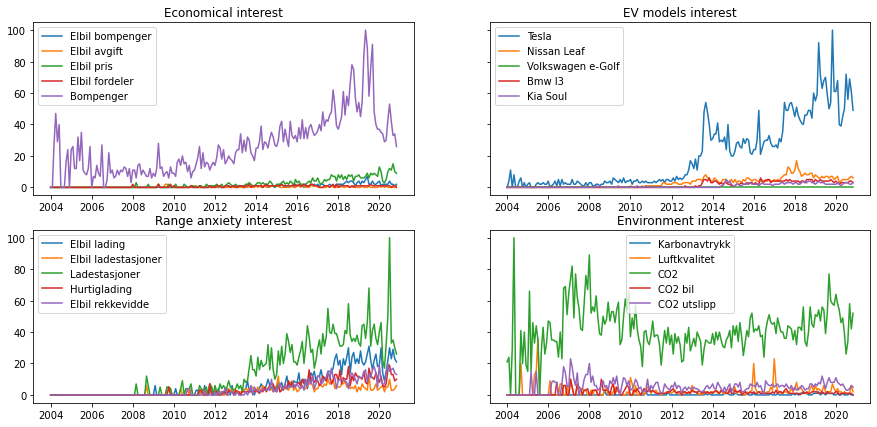

In [172]:
fig, axs = plt.subplots(2, 2, figsize=(15,7), sharey=True)

axs[0,0].plot(interest_eco)
axs[0,0].set_title("Economical interest")
axs[0,0].legend(kw_eco)

axs[0,1].plot(interest_evm)
axs[0,1].set_title("EV models interest")
axs[0,1].legend(kw_evm)

axs[1,0].plot(interest_ran)
axs[1,0].set_title("Range anxiety interest")
axs[1,0].legend(kw_ran)

axs[1,1].plot(interest_env)
axs[1,1].set_title("Environment interest")
axs[1,1].legend(kw_env)

### Step 3 - Build key events dataset

Key events: 

- dates_eco = {	"Climate settlement announcement":"2012-04-24"    ,     "...":"..."	}
- dates_evm = {	  "...":"..."    ,     "...":"..."	}
- dates_ran = {	  "...":"..."    ,     "...":"..."	}
- dates_env = {	  "...":"..."    ,     "...":"..."	}

(if month and day not found then do: YYYY-07-15)